# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



# Imports

In [1]:
# !pip install anndata lightgbm

In [2]:
# !conda install -c conda-forge graph-tool -y 

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import tqdm
import scipy
import json

os.environ['KMP_DUPLICATE_LIB_OK']='True'

work_dir = '../output'
resource_dir = '../resources'
os.makedirs(f'{work_dir}', exist_ok=True)

In [2]:
methods = ['Random',
 'CollectRI',
 'FigR',
 'CellOracle',
 'GRaNIE',
 'ANANSE',
 'scGLUE',
 'Scenic+',
 'HKG',
 'Positive',
 'Negative',
 'Positive Control',
 'Negative Control']


# COLORS = {
#     'Random': '#74ab8c',
#     'CollectRI': '#83b17b',
#     'FigR': '#96b577',
#     'CellOracle': '#b0b595',
#     'GRaNIE': '#c9b4b1',
#     'ANANSE': '#e2b1cd',
#     'scGLUE': '#e5b8dc',
#     'Scenic+': '#dfc2e5',
#     'HKG': '#e7d2ec',
#     'Positive': 'darkblue',
#     'Negative': 'indianred',
#     'Positive Control': 'darkblue',
#     'Negative Control': 'indianred'
# }

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#56B4E9',
    'CellOracle': '#b0b595',
    'GRaNIE': '#009E73',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#D55E00',
    'Scenic+': '#dfc2e5',
    'HKGs': 'darkblue',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}
LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRaNIE': ':',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': '-',
}

In [3]:
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
control_compound = 'Dimethyl Sulfoxide'


def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign


# housekeeping genes
if False:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)

    housekeeping_genes = df.loc[:, 0]  # Gene names
    housekeeping_genes = df_train.columns[df_train.columns.isin(housekeeping_genes)].values
    np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')
else:
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)

print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

if False:
    collectRI = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
    collectRI.to_csv(f'{work_dir}/collectri.csv')


Number of housekeeping genes: 3804


In [318]:
grn_model_names = ['figr', 'celloracle', 'granie', 'scglue', 'scenicplus']

n_nets = len(grn_model_names)


grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

In [322]:
tfs_n_list = [grn.source.unique().shape[0] for grn in grn_models_dict.values()]
print(np.min(tfs_n_list), np.median(tfs_n_list), np.max(tfs_n_list))

140 389.0 557


# main run

In [449]:
from regression import format_folder
surragate_names = {
    'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
    'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
    'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
    'FigR': 'FigR', 'figr':'FigR', 'figr_sign':'FigR-signs',
    'baseline':'Baseline',
    'cov_net': 'Pearson cov',
    'GRANIE': 'GRANIE', 'granie':'GRANIE',
    'ANANSE': 'ANANSE', 'ananse':'ANANSE',
    'scGLUE': 'scGLUE', 'scglue':'scGLUE',
    'HKG': 'HKG', 'HKGs':'HKG',
    'positive-control': 'Positive Control', 'positive_control': 'Positive Control',
    'negative-control': 'Negative Control', 'negative_control':'Negative Control',
    'pearson':'APR',
    'SL':'SLA',
    'scgen_pearson':'scGEN-APR', 'scgen_lognorm':'scGEN-SLA', 'seurat_pearson':'Seurat-APR', 'seurat_lognorm':'Seurat-SLA',
}

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#96b577',
    'CellOracle': '#b0b595',
    'GRANIE': '#c9b4b1',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#e5b8dc',
    'Scenic+': '#dfc2e5',
    'HKG': '#e7d2ec',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}

LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRANIE': '-',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': ':',
    'Positive Control': '-',
    'Negative Control': '-'
}

MARKERS = {
    'Random': '.',
    'CollectRI': '.',
    'FigR': 'o',
    'CellOracle': 'd',
    'GRANIE': 'v',
    'ANANSE': 's',
    'scGLUE': 'x',
    'Scenic+': '*',
    'Positive Control': '.',
    'Negative Control': '.'
}
def plot_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n, subsample):
    mat = []
    for i_plot, norm_method in enumerate(['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm']):
    # for i_plot, norm_method in enumerate(['scgen_pearson']):
        row = []
        # for grn_model in ['negative_control', 'collectRI', 'GRANIE', 'CellOracle', 'FigR', 'scGLUE', 'scenicplus', 'positive_control']:
        for grn_model in ['negative_control', 'collectRI', 'granie', 'celloracle', 'figr', 'scglue', 'scenicplus', 'positive_control']:
            file = f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{grn_model}_{manipulate}.json'
            if not os.path.exists(file):
                print(f'Missing file: {file}')
                mean_score = np.nan
            else:
                with open(file, 'r') as f:
                    data = json.load(f)
                mean_score = data['mean_score_r2']
            row.append(mean_score)
        mat.append(row)
    mat = np.asarray(mat)

    print(mat)

    plt.figure(figsize=(8, 5))
    ax = plt.subplot(1, 1, 1)
    xticklabels = ['Negative control', 'collectRI', 'GRANIE', 'CellOracle', 'FigR', 'scGLUE', 'Scenic+', 'Positive control']
    yticklabels = ['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm']
    seaborn.heatmap(mat, ax=ax, square=True, cbar=False, xticklabels=xticklabels, yticklabels=yticklabels, annot=True, fmt='.3f')
    plt.tight_layout()
    return mat 

## Experiment with thetas

In [439]:
experiment='theta'
reg_type = 'ridge'
subsample = 200
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample}

experiment='theta',exclude_missing_genes=False,force=False, manipulate=None, subsample=200
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/ridge/theta_0.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='ridge', norm_method='seurat_lognorm', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/ridge/theta_0.0_tf_n_None/seurat_lognorm/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/ridge/theta_0.25_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='ridge', norm_method='seurat_lognorm', model_name='negative_contro

In [440]:
experiment='theta'
reg_type = 'GB'
!python regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample}

experiment='theta',exclude_missing_genes=False,force=False, manipulate=None, subsample=200
reg_type='GB', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_0.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='GB', norm_method='seurat_lognorm', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_0.0_tf_n_None/seurat_lognorm/negative_control_None.json
reg_type='GB', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
Skip running because file exists:  ../output/benchmark/scores/subsample_200/exclude_missing_genes_False/GB/theta_0.25_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='GB', norm_method='seurat_lognorm', model_name='negative_control', exclude_missing_g

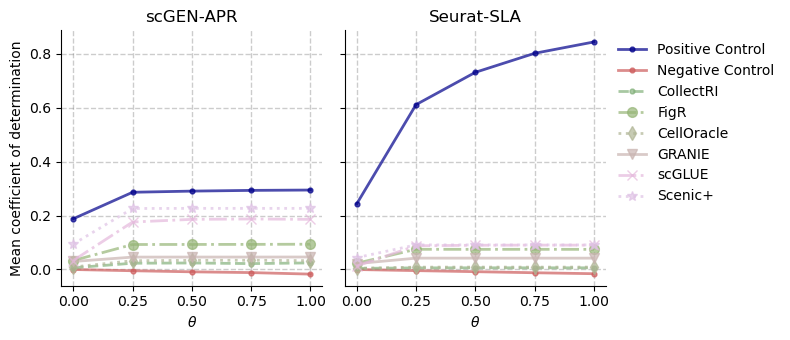

In [461]:

reg_type = 'ridge'
subsample = 200
SORTED_METHODS = ['positive_control', 'negative_control', 'collectRI', 'figr', 'celloracle', 'granie', 'scglue', 'scenicplus']
NORM_METHODS = ['scgen_pearson',  'seurat_lognorm']
manipulate = None
exclude_missing_genes = False
tf_n = None


fig, axes = plt.subplots(1, len(NORM_METHODS), figsize=(4*len(NORM_METHODS), 3.5), sharey=True)
markersize = 7
linewidth = 2
for k, norm_method,  in enumerate(NORM_METHODS):

    ax =axes[k]
    ax.grid(alpha=0.4, linewidth=1, color='grey', linestyle='--')
    xs = np.linspace(0, 1, 5)
    for method in SORTED_METHODS:

        series = []
        for theta in np.linspace(0, 1, 5):
            file =  f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{method}_{manipulate}.json'
            if not os.path.exists(file):
                print(f'Missing file: {file}')
                mean_score = np.nan
            else:
                with open(file, 'r') as f:
                    data = json.load(f)
                mean_score = data['mean_score_r2']

            series.append(float(mean_score))
        
        ax.plot(
            xs, series, label=surragate_names[method], color=COLORS[surragate_names[method]], markersize=markersize,
            linestyle=LINESTYLES[surragate_names[method]], marker=MARKERS[surragate_names[method]], alpha=0.7, linewidth=linewidth
        )

    ax.set_xticks(xs)
    ax.set_title(surragate_names[norm_method])
    if k == 0:
        ax.set_ylabel('Mean coefficient of determination')
    if k == 1:
        ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
        
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
        
    ax.set_xlabel(r'$\theta$')
    
plt.tight_layout()
plt.savefig(f'{work_dir}/benchmark/figs/first-validation-performance-theta-{reg_type}.png', dpi=300, transparent=True)
plt.show()

In [448]:
surragate_names

{'CollectRI': 'CollectRI',
 'collectRI': 'CollectRI',
 'collectRI_sign': 'CollectRI-signs',
 'Scenic+': 'Scenic+',
 'scenicplus': 'Scenic+',
 'scenicplus_sign': 'Scenic+-signs',
 'CellOracle': 'CellOracle',
 'celloracle': 'CellOracle',
 'celloracle_sign': 'CellOracle-signs',
 'figr': 'FigR',
 'figr_sign': 'FigR-signs',
 'baseline': 'Baseline',
 'cov_net': 'Pearson cov',
 'granie': 'GRaNIE',
 'ananse': 'ANANSE',
 'scglue': 'scGLUE',
 'positive_control': 'Positive Control',
 'negative_control': 'Negative Control',
 'pearson': 'Pearson',
 'SL': 'SLA'}

## Default run


In [436]:
# EXPERIMENT: default 
experiment = 'default'
reg_type = 'ridge'
# subsample=200 
!python regression.py --experiment {experiment} --reg_type {reg_type}  --force

experiment='default',exclude_missing_genes=False,force=True, manipulate=None, subsample=None
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 2170)
score_r2:  -0.01642743568570824 loss_mse:  0.17421307
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='positive_control', exclude_missing_genes=False
(15215, 1056) (15215, 2170)
score_r2:  0.2922619228082271 loss_mse:  0.121304475
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/scgen_pearson/positive_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='collectRI', exclude_missing_genes=False
(15215, 1178) (15215, 2170)
score_r2:  0.02429400573737975 loss_mse:  0.16723347
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/the

Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/pearson/negative_control_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/pearson/collectRI_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/pearson/granie_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/pearson/celloracle_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/pearson/figr_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/pearson/scglue_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/pearson/scenicplus_None.json
Missing file: ../output/benchmark/sc

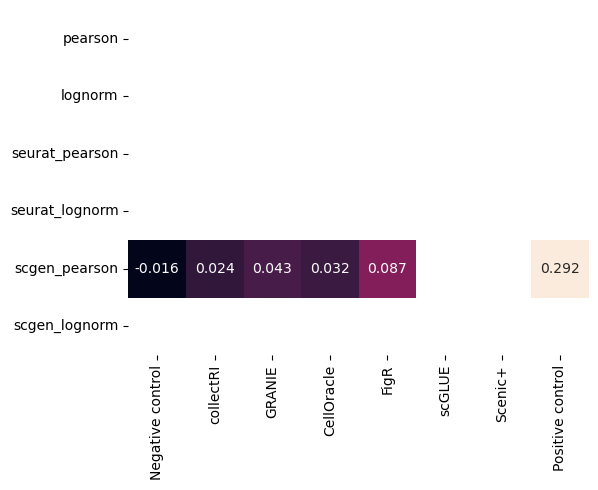

In [437]:
from regression import format_folder
reg_type = 'ridge'
exclude_missing_genes = False 
manipulate=None
subsample=None
theta = 1.0
tf_n = None

mat = plot_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n, subsample)
# plt.savefig('../output/benchmark/figs/first-validation-heatmap.png', dpi=300, transparent=True)

In [422]:
df = pd.DataFrame(mat, index=['pearson','lognorm','scgen_pearson','scgen_lognorm','seurat_pearson','seurat_lognorm'])
df.T.corr().style.background_gradient(cmap='Blues')

,pearson,lognorm,scgen_pearson,scgen_lognorm,seurat_pearson,seurat_lognorm
pearson,1.000000,0.935167,0.999867,0.942421,0.977960,0.957098
lognorm,0.935167,1.000000,0.933446,0.999411,0.845352,0.991483
scgen_pearson,0.999867,0.933446,1.000000,0.940922,0.979358,0.956212
scgen_lognorm,0.942421,0.999411,0.940922,1.000000,0.858228,0.995348
seurat_pearson,0.977960,0.845352,0.979358,0.858228,1.000000,0.889396
seurat_lognorm,0.957098,0.991483,0.956212,0.995348,0.889396,1.000000


## default run + exclude missing genes

In [346]:
experiment = 'default'
reg_type = 'ridge'
!python regression.py --experiment {experiment} --reg_type {reg_type} --force --exclude-missing-genes

experiment='default',exclude_missing_genes=True,force=True, manipulate=None
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=True
(15215, 400) (15215, 200)
score_r2:  -0.016612762329225175 loss_mse:  0.1865864117021554
../output/benchmark/scores/exclude_missing_genes_True/ridge/theta_1.0_tf_n_None/pearson/negative_control_None.json
reg_type='ridge', norm_method='lognorm', model_name='negative_control', exclude_missing_genes=True
(15215, 400) (15215, 200)
score_r2:  -0.017152455995812013 loss_mse:  0.9809621829288845
../output/benchmark/scores/exclude_missing_genes_True/ridge/theta_1.0_tf_n_None/lognorm/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=True
(15215, 400) (15215, 200)
score_r2:  -0.017464496154509918 loss_mse:  0.15386525
../output/benchmark/scores/exclude_missing_genes_True/ridge/theta_1.0_tf_n_None/scgen_pearson/negative_control_None.json
reg_type='r

[[-0.01127845  0.01181294  0.109653    0.28262569  0.05580224  0.20469301
   0.25004018  0.60633407]
 [-0.00959585 -0.00869576  0.13713612  0.09616268  0.12361777  0.19857344
   0.13787708  0.68973097]
 [-0.01252796  0.01722805  0.11131534  0.28635953  0.06678288  0.2278714
   0.27390901  0.61233146]
 [-0.00890885 -0.00825816  0.1549705   0.11283895  0.14359642  0.22611121
   0.1623767   0.67969527]
 [-0.01099245  0.0169481   0.12364396  0.33176983  0.08414715  0.27171517
   0.31144854  0.50558587]
 [-0.00915278  0.00752669  0.26691031  0.1878261   0.24750811  0.37201323
   0.2786528   0.90567885]]


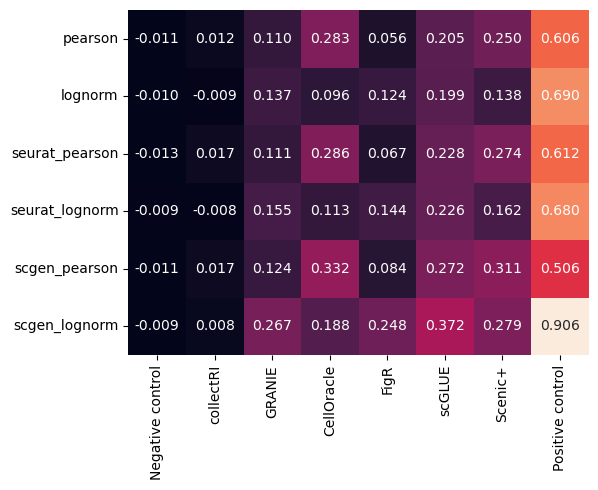

In [425]:
reg_type = 'GB'
exclude_missing_genes = True 
manipulate=None

theta = 1.0
tf_n = None

mat = plot_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n)

In [426]:
df = pd.DataFrame(mat, index=['pearson','lognorm','scgen_pearson','scgen_lognorm','seurat_pearson','seurat_lognorm'])
df.T.corr().style.background_gradient(cmap='Blues')

,pearson,lognorm,scgen_pearson,scgen_lognorm,seurat_pearson,seurat_lognorm
pearson,1.000000,0.912868,0.998933,0.917382,0.966901,0.912715
lognorm,0.912868,1.000000,0.908638,0.998379,0.810662,0.988346
scgen_pearson,0.998933,0.908638,1.000000,0.915085,0.974270,0.913639
scgen_lognorm,0.917382,0.998379,0.915085,1.000000,0.827339,0.995297
seurat_pearson,0.966901,0.810662,0.974270,0.827339,1.000000,0.841759
seurat_lognorm,0.912715,0.988346,0.913639,0.995297,0.841759,1.000000


## Mean scores of exclude and default

## Sign default

In [358]:
# EXPERIMENT: default 
experiment = 'default'
reg_type = 'ridge'
manipulate = 'signed'
!python regression.py --experiment {experiment} --reg_type {reg_type} --manipulate {manipulate} --force

experiment='default',exclude_missing_genes=False,force=True, manipulate='signed'
reg_type='ridge', norm_method='pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.016367912136892926 loss_mse:  0.1938927607642767
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/pearson/negative_control_signed.json
reg_type='ridge', norm_method='lognorm', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.017203451145185737 loss_mse:  1.010754004577529
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/lognorm/negative_control_signed.json
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 400) (15215, 200)
score_r2:  -0.0173147415934752 loss_mse:  0.16428173
../output/benchmark/scores/exclude_missing_genes_False/ridge/theta_1.0_tf_n_None/scgen_pearson/negative_control_signed.js

[[-0.01636791  0.0178293   0.0439036   0.23379257  0.07765709  0.19815969
   0.16032333  0.38881402]
 [-0.01720345  0.00514996  0.04250681  0.06090479  0.06496347  0.10668289
   0.09815565  0.71611659]
 [-0.0168611   0.01968595  0.04735804  0.23872984  0.08448741  0.21096439
   0.17214669  0.37870165]
 [-0.01581932  0.00602754  0.04790993  0.0704945   0.07438604  0.12324665
   0.11452757  0.68963342]
 [-0.01731474  0.02424059  0.05207178  0.27761642  0.09365135  0.23587843
   0.19588084  0.33007122]
 [-0.01645906  0.01372226  0.08974608  0.13571944  0.14043583  0.23239185
   0.21774453  0.82853885]]


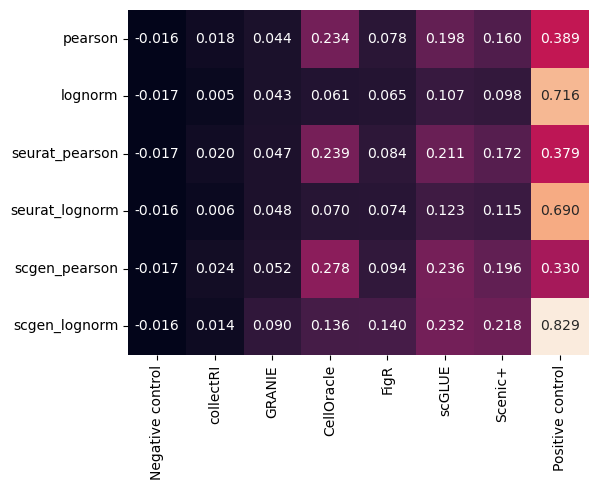

In [359]:
reg_type = 'ridge'
exclude_missing_genes = False 
manipulate='signed'

theta = 1.0
tf_n = None

plot_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n)

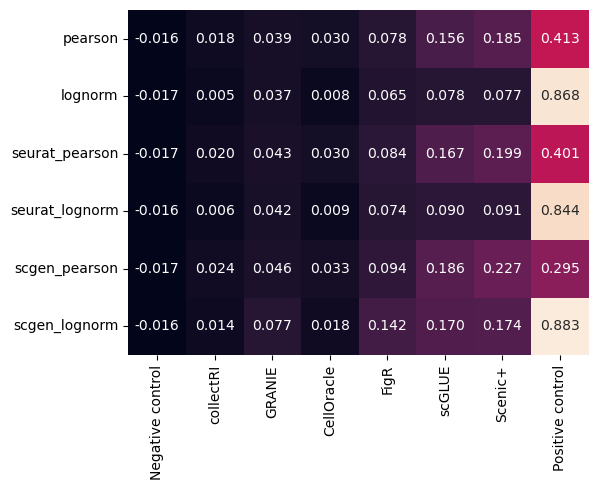

## experiment with tf-n

In [438]:
# EXPERIMENT: different tfs_n
experiment='tf_n'
reg_type = 'ridge'
# subsample=200 
!python regression.py --experiment {experiment} --reg_type {reg_type}  --force

experiment='tf_n',exclude_missing_genes=False,force=True, manipulate=None, subsample=None
reg_type='ridge', norm_method='scgen_pearson', model_name='negative_control', exclude_missing_genes=False
(15215, 140) (15215, 2170)
score_r2:  -0.006185072254513307 loss_mse:  0.1724575
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1_tf_n_140/scgen_pearson/negative_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='positive_control', exclude_missing_genes=False
(15215, 140) (15215, 2170)
score_r2:  0.2691474706632551 loss_mse:  0.12526627
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1_tf_n_140/scgen_pearson/positive_control_None.json
reg_type='ridge', norm_method='scgen_pearson', model_name='collectRI', exclude_missing_genes=False
(15215, 140) (15215, 2170)
score_r2:  0.0176844747352873 loss_mse:  0.16836634
../output/benchmark/scores/subsample_None/exclude_missing_genes_False/ridge/theta_1_tf_n_140